# Tensorflow practical, part 2, multilayer perceptron

Implement the multilayer perceptron for multiclass classification and train it for sci-kit learn “Labeled Faces in the Wild” dataset which has 7 classes.

* Train the network with mini-batch gradient descend. Choose the batch size that works best for you.
* Compute the confusion matrix.
* Test several different optimizers and choose the one which leads to the fastest convergence.
* Experiment with the way you initialize the W values. Print values for dL/dW and confirm that the gradients of ```tanh``` are zero when the initial weights are from zero to one.
* Try using different non-linearities for the hidden layer and compare the results.
* Try to add more hidden layers. Does it help to improve the results. What is the optimal number of the hidden layers for this dataset?

In [142]:
% matplotlib inline
import matplotlib.pyplot as plt
import logging
import numpy as np
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_lfw_people

print(__doc__)

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')

batch_size = 100
classes = 7
n_epoch = 100

# set random seed to reproduce the results if necessary
seed = 5
np.random.seed(seed)
tf.set_random_seed(seed)

# #############################################################################
# Download the data, if not already on disk and load it as numpy arrays
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target

target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

# split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

print('X_train.shape: ', X_train.shape)
print('X_test.shape: ', X_test.shape)
print('y_train.shape: ', y_train.shape)
print('y_test.shape: ', y_test.shape)

y_train = tf.cast(tf.one_hot(y_train, n_classes), tf.float32)
y_test = tf.one_hot(y_test, n_classes)


Automatically created module for IPython interactive environment
Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7
X_train.shape:  (966, 1850)
X_test.shape:  (322, 1850)
y_train.shape:  (966,)
y_test.shape:  (322,)


In [145]:
def network(x):
    W1 = tf.Variable(tf.random_normal([n_features, 256]), name="W1")
    b1 = tf.Variable(tf.zeros([256]), name="b1")

    W2 = tf.Variable(tf.random_normal([256, 256]), name="W2")
    b2 = tf.Variable(tf.zeros([256]), name="b2")

    W_out = tf.Variable(tf.random_normal([256, n_classes]), name="W_out")
    b_out = tf.Variable(tf.zeros([n_classes]), name="b_out")

    layer1_pre = tf.matmul(x, W1) + b1  # tf.add function does the same I guess
    layer1 = tf.nn.tanh(layer1_pre)

    layer2_pre = tf.matmul(layer1, W2) + b2  # tf.add function does the same I guess
    layer2 = tf.nn.tanh(layer2_pre)

    return tf.matmul(layer2, W_out) + b_out
    

epoch: 0, loss: 9.715700, train_acc: 0.2774, test_acc: 0.2888
epoch: 1, loss: 4.955817, train_acc: 0.2184, test_acc: 0.2360
epoch: 2, loss: 2.481773, train_acc: 0.3768, test_acc: 0.4130
epoch: 3, loss: 1.882383, train_acc: 0.3923, test_acc: 0.4534
epoch: 4, loss: 1.821281, train_acc: 0.3923, test_acc: 0.4472
epoch: 5, loss: 1.827404, train_acc: 0.2474, test_acc: 0.3012
epoch: 6, loss: 1.782716, train_acc: 0.1946, test_acc: 0.1894
epoch: 7, loss: 1.770151, train_acc: 0.4017, test_acc: 0.4441
epoch: 8, loss: 1.720107, train_acc: 0.4037, test_acc: 0.4503
epoch: 9, loss: 1.731411, train_acc: 0.4089, test_acc: 0.4503
epoch: 10, loss: 1.736526, train_acc: 0.1325, test_acc: 0.1087
epoch: 11, loss: 1.794338, train_acc: 0.4027, test_acc: 0.4503
epoch: 12, loss: 1.749491, train_acc: 0.4058, test_acc: 0.4441
epoch: 13, loss: 1.731282, train_acc: 0.4120, test_acc: 0.4441
epoch: 14, loss: 1.723335, train_acc: 0.1532, test_acc: 0.1149
epoch: 15, loss: 1.726075, train_acc: 0.4068, test_acc: 0.4410
ep

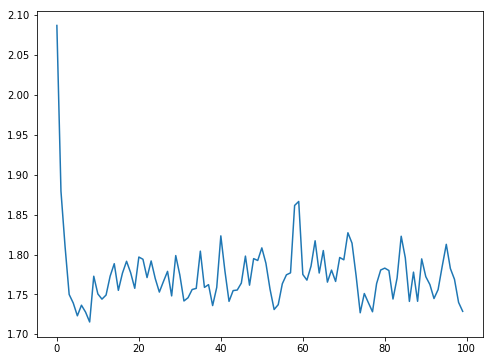

In [146]:
x_input = tf.placeholder(tf.float32, shape=[None, n_features])
y_out = tf.placeholder(tf.float32, shape=[None, n_classes])

net = network(x_input)
layer_out = tf.nn.softmax(net)
p = layer_out
    
# TensorFlow is not flexible for types. Explicit conversion is necessary each time
correct_pred = tf.equal(tf.argmax(p, 1), tf.argmax(y_out, 1))
# reduction operations like mean and sum are done in numpy style
acc = tf.reduce_mean(tf.cast(correct_pred, "float"))

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=net, labels=y_out))
# loss = tf.reduce_mean(-tf.reduce_sum(y_out * tf.log(p), reduction_indices=[1]))
optimizer = tf.train.AdamOptimizer(learning_rate=.01)
train = optimizer.minimize(loss)

indeces = list(range(X_train.shape[0]))

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    train_loss_epoch = []
    rng_minibatches = range(0, X_train.shape[0] - batch_size + 1, batch_size)
    
    for i in range(0, n_epoch):
        train_loss = 0
        np.random.shuffle(indeces)
        
        for start_idx in rng_minibatches:
            ind = indeces[start_idx:(start_idx + batch_size)]
            X_train_batch = X_train[ind]
            y_train_batch = y_train.eval()[ind]
            
            train.run(feed_dict={x_input: X_train_batch, y_out: y_train_batch})
            [loss_value] = sess.run([loss], feed_dict={x_input:X_train_batch, y_out: y_train_batch})
            
            train_loss += loss_value
    
        test_acc = sess.run(acc, feed_dict={x_input:X_test, y_out: y_test.eval()})
        train_acc = sess.run(acc, feed_dict={x_input:X_train, y_out: y_train.eval()})
        train_loss = train_loss / len(rng_minibatches)
        
        train_loss_epoch.append(train_loss)
        print('epoch: {}, loss: {:4f}, train_acc: {:.4f}, test_acc: {:.4f}'.format(i, train_loss, train_acc, test_acc))
        
    plt.figure(figsize=(8, 6))
    plt.plot(loss_train_epoch, label='Loss')